## Extraido de 
https://nbviewer.org/github/QuantEcon/QuantEcon.notebooks/blob/master/aiyagari_continuous_time.ipynb

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import spsolve

In [4]:
class Household(object):
    def __init__(self,
                 dep=0.05,   ###ADDED DEPRECIATION
                 r=0.03,         # interest rate
                 w=1,            # wages
                 rho=0.04,       # discount factor
                 a_min=1e-10,    # minimum asset amount
                 pi=[[-0.33, 0.33], [0.33, -0.33]],  # poisson Jumps
                 z_vals=[1.0, 2.0],                # exogenous income states
                 a_max=40,
                 a_size=1000,    # number of asset grid points
                 delta=1000.0):
        # Initialize values, and set up grids over a and z
        self.r, self.w, self.rho, self.dep = r, w, rho, dep
        self.a_min, self.a_max, self.a_size = a_min, a_max, a_size
        self.da = (self.a_max-self.a_min)/(self.a_size-1)
        self.k = 10
        self.pi = np.asarray(pi)
        self.z_vals = np.asarray(z_vals)
        self.z_size = len(z_vals)
        self.a_vals = np.linspace(self.a_min, self.a_max, self.a_size)
        self.n = self.a_size * self.z_size
        self.delta = delta
        ###### ADDED TO MATCH LABOR SUPPLY IN .m
        self.z_ave = (self.z_vals[0]*self.pi[0, 1] +
                      self.z_vals[1]*self.pi[1, 0]) / \
            (self.pi[0, 1] + self.pi[1, 0])
        
        # Initial Guess of Value Function
        self.v = np.log(np.tile(self.a_vals,(self.z_size,1))*self.r
                        +self.w*np.tile(self.z_vals,(self.a_size,1)).transpose())/self.rho
        
        # Build skill_transition, the matrix summarizing transitions due to the Poisson income shocks
        # This is analogous to the Q matrix in the discrete time version of the QuantEcon Aiyagari model
        self.z_transition = sparse.kron(self.pi,sparse.eye(self.a_size), format="csr")
        
        # Preallocation
        self.v_old = np.zeros((self.z_size,self.a_size))
        self.g = np.zeros((self.z_size,self.a_size))
        self.dv = np.zeros((self.z_size,self.a_size-1))
        self.cf = np.zeros((self.z_size,self.a_size-1))
        self.c0 = np.zeros((self.z_size,self.a_size))
        self.ssf = np.zeros((self.z_size,self.a_size))
        self.ssb = np.zeros((self.z_size,self.a_size))
        self.is_forward = np.zeros((self.z_size,self.a_size),'bool')
        self.is_backward = np.zeros((self.z_size,self.a_size),'bool')
        self.diag_helper = np.zeros((self.z_size,self.a_size))        
        self.A = self.z_transition.copy()
        self.B = self.z_transition.copy()
        self.AT = self.z_transition.copy()

    def set_prices(self, r, w):
        """
        Resets prices
        Calling the method will resolves the Bellman Equation.
        
        Parameters:
        -----------------
        r : Interest rate
        w : wage
        """
        self.r, self.w = r, w
        self.solve_bellman()

    def reinitialize_v(self):
        """
        Reinitializes the value function if the value function
        became NaN
        """
        self.v = np.log(np.tile(self.a_vals,(self.z_size,1))*self.r
                        +self.w*np.tile(self.z_vals,(self.a_size,1)).transpose())/self.rho

    def solve_bellman(self,maxiter=100,crit=1e-6):
        """
        This function solves the decision problem with the given parameters
        
        Parameters:
        -----------------
        maxiter : maximum number of iteration before haulting value function iteration
        
        crit : convergence metric, stops if value function does not change more than crit
        """
        dist=100.0
        for i in range(maxiter):
            # compute saving and consumption implied by current guess for value function, using upwind method
            self.dv = (self.v[:,1:]-self.v[:,:-1])/self.da
            self.cf = 1.0/self.dv
            self.c0 = np.tile(self.a_vals,(self.z_size,1))*self.r \
                            +self.w*np.tile(self.z_vals,(self.a_size,1)).transpose()

            # computes savings with forward forward difference and backward difference
            self.ssf[:,:-1] = self.c0[:,:-1]-self.cf
            self.ssb[:,1:] = self.c0[:,1:]-self.cf
            # Note that the boundary conditions are handled implicitly as ssf will be zero at a_max and ssb at a_min 
            self.is_forward = self.ssf>0
            self.is_backward = self.ssb<0
            # Update consumption based on forward or backward difference based on direction of drift
            self.c0[:,:-1] += (self.cf-self.c0[:,:-1])*self.is_forward[:,:-1]
            self.c0[:,1:] += (self.cf-self.c0[:,1:])*self.is_backward[:,1:]
            ######
            # UNCOMMENT FOR DEBUGGING
            #plt.plot(self.a_vals, self.c0.transpose())
            #plt.show()
            self.c0 = np.log(self.c0)
            
            # Build the matrix A that summarizes the evolution of the process for (a,z)
            # This is a Poisson transition matrix (aka intensity matrix) with rows adding up to zero
            self.A = self.z_transition.copy()
            self.diag_helper = (-self.ssf*self.is_forward/self.da \
                               + self.ssb*self.is_backward/self.da).reshape(self.n)
            self.A += sparse.spdiags(self.diag_helper,0,self.n,self.n)
            self.diag_helper = (-self.ssb*self.is_backward/self.da).reshape(self.n)
            self.A += sparse.spdiags(self.diag_helper[1:],-1,self.n,self.n)
            self.diag_helper = (self.ssf*self.is_forward/self.da).reshape(self.n)
            self.A += sparse.spdiags(np.hstack((0,self.diag_helper)),1,self.n,self.n)
            # Solve the system of linear equations corresponding to implicit finite difference scheme
            self.B = sparse.eye(self.n)*(1/self.delta + self.rho) - self.A
            self.b = self.c0.reshape(self.n,1) + self.v.reshape(self.n,1)/self.delta
            self.v_old = self.v.copy()
            self.v = spsolve(self.B,self.b).reshape(self.z_size,self.a_size)

            # Compute convergence metric and stop if it satisfies the convergence criterion
            dist = np.amax(np.absolute(self.v_old-self.v).reshape(self.n))
            if dist < crit:
                break

    def compute_stationary_distribution(self):
        """
        Solves for the stationary distribution given household decision rules
        
        Output:
        Capital level from the stationary distribution
        """        
        self.AT = self.A.transpose().tocsr()

        # The discretized Kolmogorov Forward equation AT*g=0 is an eigenvalue problem
        # AT is singular because one of the equation is the distribution adding
        # up to 1. Here we solve the eigenvalue problem by setting g(1,1)=0.1
        # and the equation is solved relative to that value.
        # Alternatively, one could use a routine for solving eigenvalue problems.
        b = np.zeros((self.n,1))
        b[0] = 0.1
        self.AT.data[1:self.AT.indptr[1]] = 0
        self.AT.data[0] = 1.0
        self.AT.indices[0] = 0
        self.AT.eliminate_zeros()
        self.g = spsolve(self.AT,b).reshape(self.z_size,self.a_size)
        
        # Since g was solved taking one of g(1,1) as given, g needs to be
        # renormalized to add up to 1
        self.g = self.g/np.sum(self.g)
        return np.sum(self.g*(np.tile(self.a_vals,(self.z_size,1))))

In [5]:
lam = 0.11
PI = [[-lam, lam], [lam, -lam]]
am=Household(rho=0.05, r=0.02,w=1, pi=PI)
am.solve_bellman()
am.compute_stationary_distribution()

np.float64(0.6927464134085084)

In [6]:
am.r=0.02
am.w=0.9

In [7]:
am.solve_bellman()
am.compute_stationary_distribution()

np.float64(0.6232372053476659)

In [8]:
am.set_prices(r=0.03,w=0.9)
am.compute_stationary_distribution()

np.float64(1.1298333088364787)

In [9]:
A = 0.1
##### NOT NECESSARY
#N = 0.05
alpha = 0.33

def r_to_w(am, r):
    return A*(1 - alpha) * \
        (alpha*A / (am.dep + r))**(alpha / (1 - alpha))

def rd(am, K):
    return A*alpha*(am.z_ave / K)**(1 - alpha) - am.dep

def prices_to_capital_stock(am, r):
    """
    Map prices to the induced level of capital stock.
    
    Parameters:
    ----------
    am : Household
        An instance of the Household class
    r : float
        The interest rate
    """
    w = r_to_w(am, r)

    # Set new prices and solve the Bellman equation
    am.set_prices(r, w)

    # Compute the stationary distribution and capital
    return am.compute_stationary_distribution()

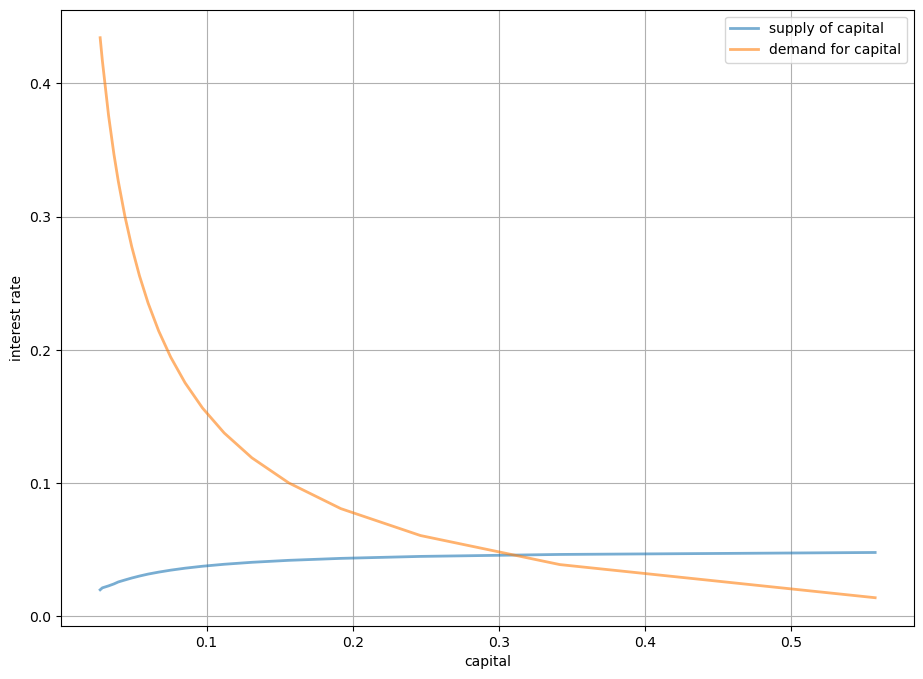

In [10]:
num_points = 20
r_vals = np.linspace(0.02, 0.048, num_points)

# Compute supply of capital
k_vals = np.empty(num_points)
for i, r in enumerate(r_vals):
    k_vals[i] = prices_to_capital_stock(am,r)

# Plot supply and demand of capital
fig, ax = plt.subplots(figsize=(11, 8))
ax.plot(k_vals, r_vals, lw=2, alpha=0.6, label='supply of capital')
ax.plot(k_vals, rd(am, k_vals), lw=2, alpha=0.6, label='demand for capital')
ax.grid()
ax.set_xlabel('capital')
ax.set_ylabel('interest rate')
ax.legend(loc='upper right')
plt.show()

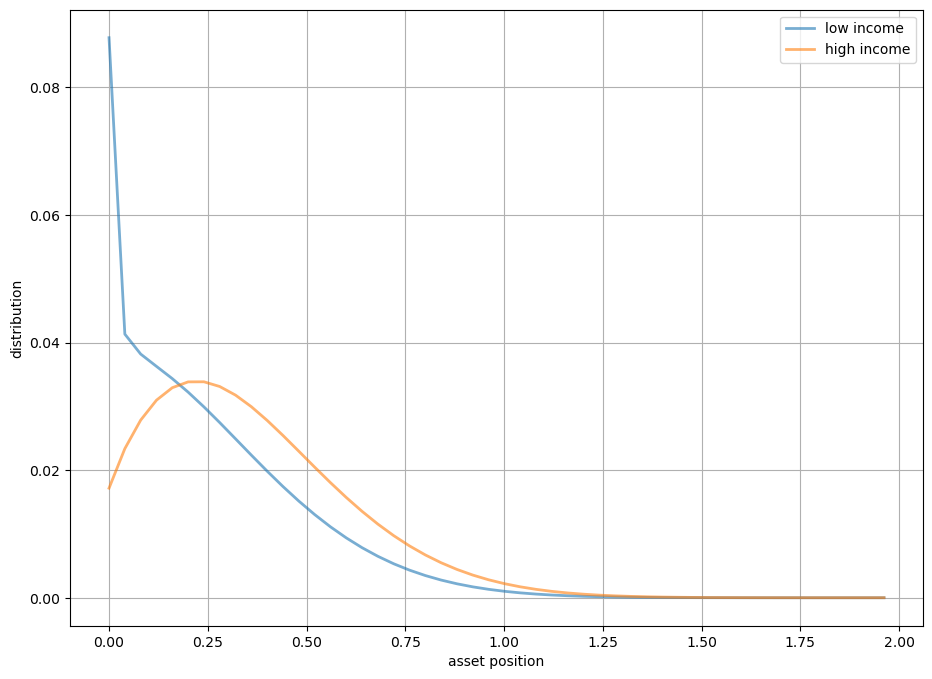

In [11]:
# Set parameters for bisection method
crit = 1e-6
r_min = 0.02
r_max = 0.05
r = 0.03

# Bisection loop
for i in range(100):
    am.set_prices(r,r_to_w(am, r))
    r_new = rd(am, am.compute_stationary_distribution())
    if np.absolute(r_new-r)<crit:
        break
    elif r_new > r:
        r_min = r
        r = (r_max+r_min)/2.
    else:
        r_max = r
        r = (r_max+r_min)/2.

# Plot stationary distribution at the equilibrium
fig, ax = plt.subplots(figsize=(11, 8))
n=50                      # Determine the max asset level to show in the plot
ax.plot(am.a_vals[0:n], am.g[0,0:n], lw=2, alpha=0.6, label='low income')
ax.plot(am.a_vals[0:n], am.g[1,0:n], lw=2, alpha=0.6, label='high income')
ax.grid()
ax.set_xlabel('asset position')
ax.set_ylabel('distribution')
ax.legend(loc='upper right')
plt.show()

In [21]:
am.r ;
am.w

0.0395843783478113

In [17]:
am.w

0.0395843783478113